## PHYS 211/334 Python Example Scripts
## Example 4 - Fitting Peaks in a PHA Spectrum

- **PROGRAM**: This script reads in a typical spectrum file and fits a portion of it to a Gaussian function using the least-squares technique.
- **INPUT**:  Example4_Data.tsv
- **CREATED**: 9-11-2014
- **AUTHOR**: David McCowan [modified from work by William Irvine (2012), Frank Merrit (2013) and Michael Fedderke (2013)]
- **EDITED**: 08-12-2016, converted from python script to ipython notebook
- **EDITED**: 07-27-2017, minor tweaks, updated to python3
- **EDITED**: 09-12-2018, fixed Jupyter formatting issues
- **REVISED**: 08-21-2020, updated to in-notebook exercises (Kevin Van De Bogart)

# Part 1
---
You know the drill by now: start with importing libraries and defining our data file's name.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
data_filename = 'Example4_Data.tsv'
using_colab = False

In [2]:
if using_colab:
  from google.colab import files
  uploaded = files.upload()
  data_filename = next(iter(uploaded.keys()))
  # This last line is a trick that will automatically pull the filename from what you uploaded.

We're loading a file from one of our PHA spectra this time, and these come with some additional notes before the data starts, as you can see below:

![](https://wiki.uchicago.edu/download/attachments/127403926/Example4_DataScreenshot.png?version=1&modificationDate=1598041326000&api=v2)

To deal with this, we're goint to use Python in to detect where the data starts.  Understanding this isn't expected for the course, so don't agonize about how it functions.

In [2]:
f = open( data_filename ,"r")
data_start = 0
for x,line in enumerate(f):
    if(line == 'Channel Data:\n'): #reads the file until it finds this text, which always occurs two lines before the data starts
        f.close()
        data_start = x+2
        print("Data starts on row {}".format(data_start))
        break

Data starts on row 22


Now that we have the start row, we can read in the data from file using `np.loadtxt()`. This time we have only `x` and `y` data (no uncertainties).

In counting data such as this, we can assume our counts are Poisson-distributed and take the uncertainty to be $dN = \sqrt N$ for large `N`.
- For small `N` (say, `N < 20`), this is a slight underestimate, and as $N \rightarrow 0$, this is totally wrong. 
  - `dN = 0` means we know `N = 0` *exactly*... always and forever, no ifs and or buts. This is incorrect.
- To deal with `N = 0`, we use `dN = 1.4` which represents the one-sided 68% confidence level upper limit. (For some justification, see http://statpages.org/confint.html.)

In [3]:
data = np.loadtxt( data_filename , unpack=True, skiprows = data_start) #numpy opens the data starting at the appropriate place
print(data)

[[0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]


Unlike before, we didn't break the columns apart right away.  This because we're making a generic script, that will work if there are either two columns (Channel and Counts) or three (Channel, Energy, and Counts).

The `data` variable we got back for this instance is an array with two elements, each of which is another array.  We're going to access these individually and rename them to store the columns of our data.

To access part of an array, we use square brackets `[]` after a variable name, with the index we want inside the brackets.  `data[0]` gives us the first column of our data, which is the channels.

In [5]:
channel = data[0]

Now we'll use some logic to figure out how to break the columns out the rest of the way.  If you already know how to code you can skip ahead and see how we're doing this in Python, if not then keep reading.

> If there aren't any energies then there will only be two elements in `data`.  The way to test for this in Python is to check if the length of the data array, `len(data)` is equal to 2: `len(data == 2)`

> To make it so that code only runs if a condition is true, we use an `if` statement that begins with a statement like `if (condition):`  Any code after this that is indented will only be run if the condition we evaluated was true.

> `else:` is a complement to `if`, it only runs the indented code after it if the condition we evaluated was false.  

> If you haven't programmed before, it is standard practice for a single equals sign to be used to assign quantities to a variable (`x=3` sets the variable `x` to `3`) and a double sign to be used for logic (`x==3` is `True` if `x` is 3, and `False` otherwise) 

In [4]:
if(len(data)==2): # If you didn't calibrate the energies, the second row contains the particle counts
    N = data[1]
else:
    Energy = data[1]
    N = data[2]

dN = np.sqrt(N)

Now let's talk about loops for a moment.  If you already know Python, feel free to skip ahead.

> Python has a very compact way of letting us access every element in an array one at a time in its `for` loop syntax.  In the code below, we have the statement `for value in dN:` to start the loop.  What this does is create a temporary variable (`value`) for the first element in `dN`, and then run the code in the loop: `print(value)`.  This results in us getting a line-by-line list of everything that's in dN.

> If you've worked in other programming languages, you may have made loops a very different way by specifying start and stop values, which break horribly if you mess up the code even a little.  The fact that Python can intelligently handle the nitty gritty aspects of this for you is part of why we're using it for this class, and part of why it is an extremely popular language.

In [5]:
for value in dN:
  print(value)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
2.0
2.0
1.0
1.7320508075688772
2.6457513110645907
1.0
1.0
0.0
2.0
3.1622776601683795
19.05255888325765
23.173260452512935
23.874672772626646
23.727621035409346
23.194827009486403
23.53720459187964
24.698178070456937
23.979157616563597
23.49468024894146
23.40939982143925
24.0
22.978250586152114
23.021728866442675
23.08679276123039
23.173260452512935
23.194827009486403
23.2163735324878
24.228082879171435
23.811761799581316
24.413111231467404
23.2163735324878
23.979157616563597
23.600847442411894
23.558437978779494
24.515301344262525
23.748684174075834
24.310491562286437
23.558437978779494
24.24871130596428
24.041630560342615
24.228082879171435
23.345235059857504
24.145392935299274
24.041630560342615
24.06241883103193
23.664319132398465
22.9128784747792
24.392621835300936
24.228082879171435
24.939927826679853
23.811761799581316
24.657656011875904
25.15949125081825
24.73863375370596
23.853720883753127
24.657656011875904
25.2586618

1.7320508075688772
3.0
3.0
2.449489742783178
2.8284271247461903
2.6457513110645907
3.0
2.0
2.23606797749979
2.8284271247461903
2.0
2.6457513110645907
2.8284271247461903
1.4142135623730951
3.1622776601683795
3.3166247903554
2.6457513110645907
2.23606797749979
2.0
2.23606797749979
2.449489742783178
2.449489742783178
2.449489742783178
1.7320508075688772
2.449489742783178
2.0
2.449489742783178
2.449489742783178
2.449489742783178
2.23606797749979
2.449489742783178
2.0
2.6457513110645907
2.6457513110645907
2.449489742783178
2.6457513110645907
2.8284271247461903
1.7320508075688772
3.1622776601683795
2.23606797749979
2.449489742783178
1.7320508075688772
3.872983346207417
2.449489742783178
2.8284271247461903
2.23606797749979
2.23606797749979
2.8284271247461903
2.0
3.1622776601683795
2.23606797749979
2.6457513110645907
1.7320508075688772
1.7320508075688772
3.4641016151377544
1.7320508075688772
3.0
1.4142135623730951
1.4142135623730951
2.0
2.6457513110645907
1.7320508075688772
2.0
2.4494897427831

Next we set our uncertainty values `dN = np.sqrt(N)` and then check for zeroes.  Again, if you're familiar with coding, you can skim the explanation here.

> Here we've set up the loop a little differently: `enumerate(dN)` tells Python that we want to have every single value in `dN` and the index associated with it.  The indicies are represented by `i`, and the values by `value`.  

> One by one, this checks if the ith element of `dN` is equal to zero or not.  If it is, then it replaces that specific element `dN[i]` with a value of 1.14.

In [7]:
dN = np.sqrt(N)
for i, value in enumerate(dN):
    if value == 0:
        dN[i] = 1.14

For the sake of convinience, here's all that code together in one spot.  You don't have to run it again, but it won't hurt if you do.

This snippet of code is a tool for you to use, feel free to copy it into a notebook and use it for later labs.

In [8]:
f = open( data_filename ,"r")
data_start = 0
for x,line in enumerate(f):
    if(line == 'Channel Data:\n'): #reads the file until it finds this text, which always occurs two lines before the data starts
        f.close()
        data_start = x+2
        print("Data starts on row {}".format(data_start))
        break
data = np.loadtxt( data_filename , unpack=True, skiprows = data_start) #numpy opens the data starting at the appropriate place
channel = data[0]
if(len(data)==2): # If you didn't calibrate the energies, the second row contains the particle counts
    N = data[1]
else:
    Energy = data[1]
    N = data[2]

dN = np.sqrt(N)
for i, value in enumerate(dN):
    if value == 0:
        dN[i] = 1.14

Data starts on row 22


Quickly plot the data to see what it looks like

<ErrorbarContainer object of 3 artists>

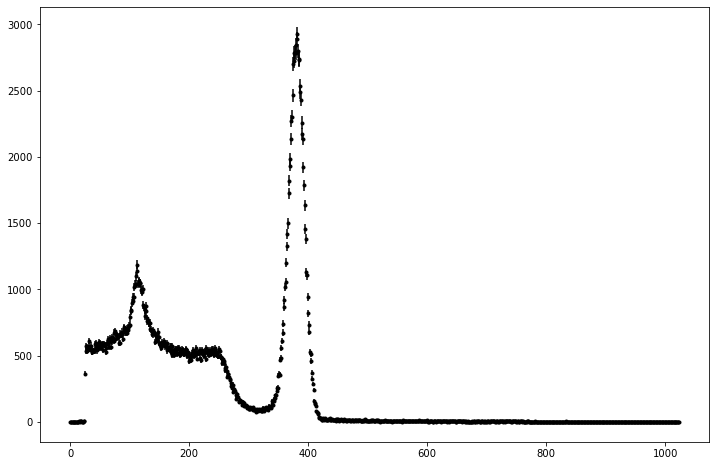

In [10]:
fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel, N, dN, fmt='k.')

You should see one clear full energy peak just short of channel 400.  let's take a closer look at it by only plotting part of the data.

To access only part of an array, you can use square brackets with the start and stop points separated with a colon.  For instance, `channel[0:99]` would give you an array with only the first 100 values of `channel` in it.  Let's use this to zoom in on our data.

<ErrorbarContainer object of 3 artists>

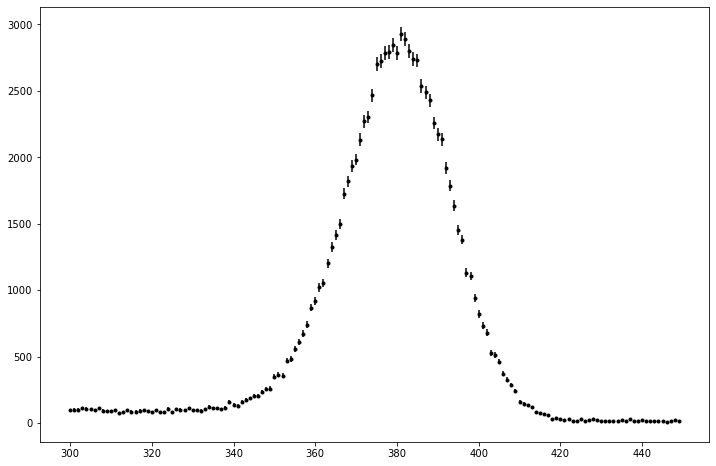

In [11]:
min_value = 300
max_value = 450
fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel[min_value:max_value], N[min_value:max_value], dN[min_value:max_value], fmt='k.')

---
# Task 1
---
Zoom in a little further on the peak, and make the plot look a bit nicer.  Specifically:
- Add a title of 'PHA Energy Spectrum of Cs-137 Decay'
- Label the x axis 'channel' and the y axis 'counts'
- Add a legend and label your points as 'Data'
- Add endcaps to the errorbars with the `capsize` keyword.
  - If you don't remember how to do this, check the examples in the first notebook.

Text(0, 0.5, 'counts')

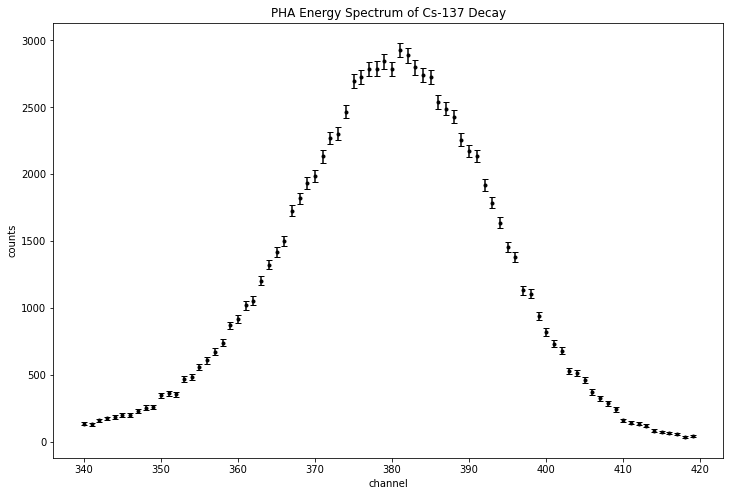

In [9]:
min_value = 340
max_value = 420
fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel[min_value:max_value], N[min_value:max_value], dN[min_value:max_value], fmt='k.', capsize=3)
ax.set_title('PHA Energy Spectrum of Cs-137 Decay')
ax.set_xlabel('channel')
ax.set_ylabel('counts')

# Part 2: Fitting a Gaussian
---

Now that you've got things gussied up, let's fit our data with a Gaussian function of the form $f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}$

In the code below, `p[0]` = $N$, `p[1]` = $\mu$, and `p[2]` = $\sigma$

In [10]:
def gaussianfunc(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

We'll bring back the same curve fitting routine we've been using in the cell below.

In [11]:
# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), -1, -1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), -1, -1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

Now we've got to make some initial guesses for appropriate parameters.
From our plot above:
- The amplitude $N$ is about 3000 counts, so lets guess 50,000 counts total
- The center $\mu$ is near channel 375
- The width is about 50 channels, so $\sigma$ is about half that: 25

With that out of the way, we need to make sure that we're only fitting the data that's acutally gaussian.  We'll use the method of selecting just a subset of data to do this, just like before.

In [34]:
channel2 = channel[min_value:max_value]
N2 = N[min_value:max_value]
dN2 = dN[min_value:max_value]

print("Gaussian Fit")
p0 = [50000, 375, 25]
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, channel2, N2, dN2)

Gaussian Fit

Converged with chi-squared 2139.42
Number of degrees of freedom, dof = 97.00
Reduced chi-squared 22.06

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 5.000e+04                | 9.404e+04                | 3.067e+02               
1           | 3.750e+02                | 3.794e+02                | 4.489e-02               
2           | 2.500e+01                | 1.363e+01                | 3.390e-02               


Huh, the reduced $\chi^2$ value is pretty large.  Let's plot our fit and see what's happening.

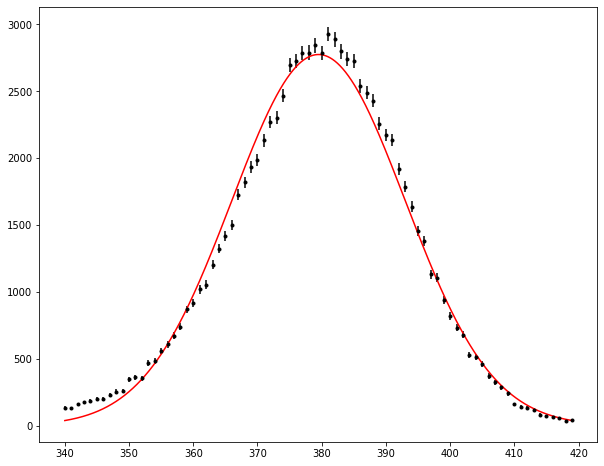

In [13]:
fig,ax = plt.subplots(figsize = (10,8))

ax.errorbar(channel2, N2, yerr=dN2,fmt= 'k.', label='Data in fit')

# We then plot the fit function. We could plot it at each point in "channel2"
#  and connect those points with straight lines. However, we may want a smoother
#  plot. To do so, we create a new array of points using "linspace()" that covers
#  the same range, but more densely. When we connect these points, the line will
#  be more smooth.
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
ax.plot(channel_cont, gaussianfunc(pf1, channel_cont), 'r-', label='Fit')


plt.savefig('Example4_Figure1.pdf')
if using_colab:
  files.download('Example4_Figure1.pdf') 
plt.show()

Our function is definitely undershooting all of the data on the left, and the center doesn't quite look like the center in our data.  We'll dig into this in just a moment, but first we want you to tidy this plot up a bit.

---
# Task 2
---
Your next task:

 - Tidy up the plot by incorporating the changes you made in exercise 1.  

 - Add a text annotation to the plot with the fit equation and fit parameters (with uncertainty)
  - If you need a reminder of how to do this, check the second tutorial notebook.  


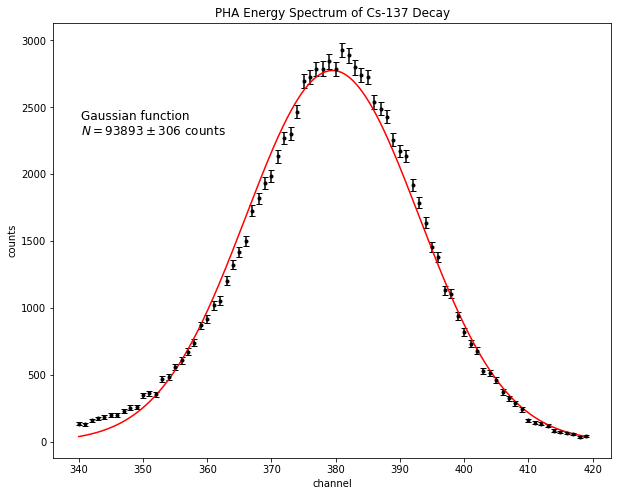

In [26]:
min_value = 340
max_value = 420

fig,ax = plt.subplots(figsize = (10,8))

ax.errorbar(channel2, N2, yerr=dN2,fmt= 'k.', label='Data in fit', capsize=3)

# We then plot the fit function. We could plot it at each point in "channel2"
#  and connect those points with straight lines. However, we may want a smoother
#  plot. To do so, we create a new array of points using "linspace()" that covers
#  the same range, but more densely. When we connect these points, the line will
#  be more smooth.
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
ax.plot(channel_cont, gaussianfunc(pf1, channel_cont), 'r-', label='Fit')


ax.set_title('PHA Energy Spectrum of Cs-137 Decay')
ax.set_xlabel('channel')
ax.set_ylabel('counts')

figText = 'Gaussian function \n'
figText+= '$N = %d \pm %d$ counts' %(pf1[0], pferr1[0])

ax.text(0.05, 0.8, figText, transform=ax.transAxes , fontsize=12,verticalalignment='top')

plt.savefig('Example4_Figure1.pdf')
if using_colab:
  files.download('Example4_Figure1.pdf') 
plt.show()

# Task 3: Using Residual Plots
---
To get a better understanding of where our fit is going awry, let's do what we did back in the second notebook: plot the residuals!

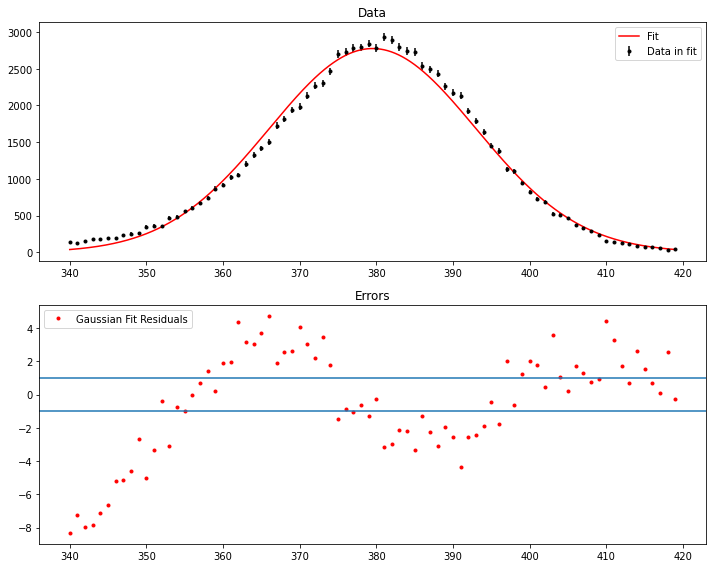

In [27]:
fig = plt.figure(figsize = (10,8))
ax =fig.add_subplot(2,1,1)
ay =fig.add_subplot(2,1,2)

ax.errorbar(channel2, N2, yerr = dN2, fmt = 'k.', label='Data in fit')
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
ax.plot(channel_cont, gaussianfunc(pf1, channel_cont), 'r-', label='Fit')

ay.plot(channel2, residual(pf1, gaussianfunc, channel2, N2, dN2), 'r.', label='Gaussian Fit Residuals')
    # A plot of just the magnitudes of the errors
ax.legend()
ay.legend()
ay.axhline(1)
ay.axhline(-1)
ax.set_title("Data")
ay.set_title("Errors")
fig.tight_layout()

Remember that the residuals are the difference between the fit line and the data itself.

If we had an excellent model for our data, then ~70% of our residuals would be between 1 and -1.  The fact that most residuals aren't in this range suggests that we're missing something systematic.

To try and ammend this, we've got one last exercise for you.

---
# Task 3
---

Your final task is to define a new gaussian function that includes a linear background term $g(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }} + mx + b$, find the best fit equation, and plot it along with the fit parameters.
- Remember that you've got two new fit parameters $m$ and $b$, so your guess will need two more values initially.
- If your function is defined correctly, the reduced $\chi^2$ value will probably be around 3 to 4, depending on what subset of the data you're looking at.
  - The example here shows dara from `[325:425]`

Your final plot should look something like the following:
![example final plot](https://wiki.uchicago.edu/download/attachments/254186703/Example4_Figure2.png?version=1&modificationDate=1600181110000&api=v2)


In [60]:
def gaussianfunc2(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2)) + p[3]*x + p[4]


min_value = 325
max_value = 425

channel2 = channel[min_value:max_value]
N2 = N[min_value:max_value]
dN = dN[min_value:max_value]

p0 = [89259, 379, 12, -1, 498]
print(p0)

pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc2, channel2, N2, dN2)



[89259, 379, 12, -1, 498]

Converged with chi-squared 284.41
Number of degrees of freedom, dof = 95.00
Reduced chi-squared 2.99

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 8.926e+04                | 9.002e+04                | 3.339e+02               
1           | 3.790e+02                | 3.800e+02                | 4.819e-02               
2           | 1.200e+01                | 1.293e+01                | 4.266e-02               
3           | -1.000e+00               | -1.158e+00               | 3.300e-02               
4           | 4.980e+02                | 4.923e+02                | 1.292e+01               


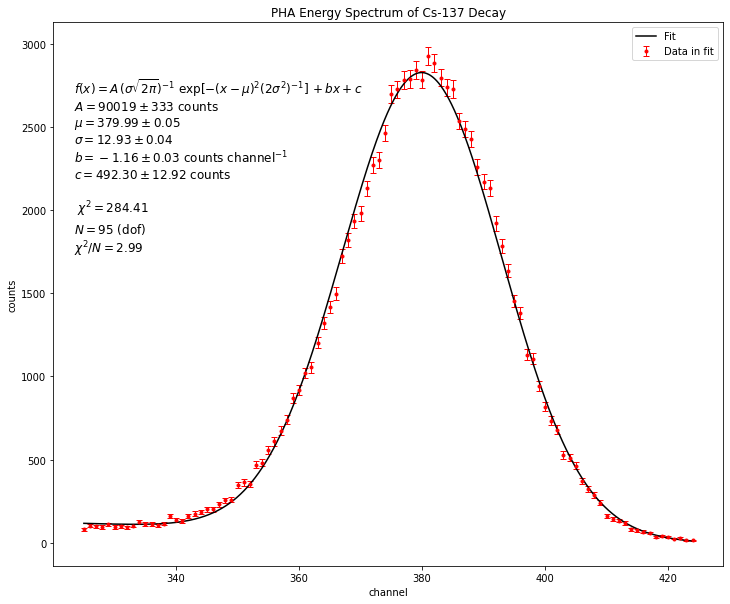

In [75]:

fig,ax = plt.subplots(figsize = (12,10))

ax.errorbar(channel2, N2, yerr=dN2,color='r', marker='.', linewidth=1, ls='none',
            label='Data in fit', capsize=3)

# We then plot the fit function. We could plot it at each point in "channel2"
#  and connect those points with straight lines. However, we may want a smoother
#  plot. To do so, we create a new array of points using "linspace()" that covers
#  the same range, but more densely. When we connect these points, the line will
#  be more smooth.
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
ax.plot(channel_cont, gaussianfunc2(pf1, channel_cont), 'k-', label='Fit')


ax.set_title('PHA Energy Spectrum of Cs-137 Decay')
ax.set_xlabel('channel')
ax.set_ylabel('counts')

figText = '$f(x) = A \, (\sigma \sqrt{2\pi})^{-1} $ exp$[-(x - \mu)^2 (2 \sigma^2)^{-1}] \, + bx + c$ \n'
figText+= '$ A = %d \pm %d$ counts \n' %(pf1[0], pferr1[0])
figText+= '$ \mu = %.2f \pm %.2f $\n' %(pf1[1], pferr1[1])
figText+= '$ \sigma = %.2f \pm %.2f $\n' %(pf1[2], pferr1[2])
figText+= '$ b = %.2f \pm %.2f $ counts channel$^{-1}$\n' %(pf1[3], pferr1[3]) 
figText+= '$ c = %.2f \pm %.2f $ counts\n' %(pf1[4], pferr1[4])
figText+= '\n $\chi^2 = %.2f$ \n' %(chisq1)
figText+= '$N = %d$ (dof) \n' %(dof1)
figText+= '$\chi^2 / N = %.2f$ \n' %(chisq1 / dof1)

ax.text(0.03, 0.9, figText, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.legend(loc='upper right')

plt.savefig('Dewhurst_Ex4Fig2.pdf')
if using_colab:
  files.download('Example4_Figure1.pdf') 
plt.show()